In [1]:
from collections import deque

buffer_max_size = 20000 #max number of episodes in a buffer
batch_size = 64 #Number of episodes to sample during each Q-value update
episodes_buffer = deque(maxlen=buffer_max_size)

In [2]:
def add_episode_to_buffer(state, action, reward, next_state, terminated):
    episode = (state, action, reward, next_state, terminated)
    episodes_buffer.append(episode)


In [3]:
import random

def sampling_batch():
    return random.sample(episodes_buffer, batch_size)

In [4]:
def storage_in_buffer():
    return len(episodes_buffer) > batch_size

In [5]:
import gym
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers,Input
import matplotlib.pyplot as plt

cartpole_env = gym.make('CartPole-v1')


c:\Users\mrnal\anaconda3\envs\final_tensor_env\Lib\site-packages\gym\core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
c:\Users\mrnal\anaconda3\envs\final_tensor_env\Lib\site-packages\gym\wrappers\step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [6]:
def build_neural_model_Q(state_space_size, action_space_size):
    model = tf.keras.Sequential([
        Input(shape=(state_space_size,)),
        layers.Dense(64, activation='relu'),
        layers.Dense(24, activation='relu'),
        layers.Dense(action_space_size, activation='linear')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.002))
    return model


In [7]:
discount_factor = 0.99
explore_epsilon = 1.0
epsilon_decay = 0.995
maximum_epsilon = 0.75
learning_value = 0.09
num_episodes = 100
num_repetitons = 5
target_steps = 2000 ##across all episodes in a run


In [8]:
state_size_sample = cartpole_env.observation_space.shape[0]
action_size_sample = cartpole_env.action_space.n
model_sample = build_neural_model_Q(state_size_sample, action_size_sample)
target_model_sample = build_neural_model_Q(state_size_sample, action_size_sample)

In [9]:
def update_target_network():
    target_model_sample.set_weights(model_sample.get_weights())
    print("Updated target network weights.")

In [10]:
# Function to choose an action using epsilon-greedy strategy
# if the explore_epsilon is lesser than the random number generated, generate a random action

def epsilon_greedy_action(state):
    if isinstance(state, tuple):
        state = state[0]
    state_reshaped = np.array(state).reshape(1, -1)

    if np.random.uniform(0, 1) > explore_epsilon:
        return cartpole_env.action_space.sample()
    else: #choose best action according to knowledge
        state_reshaped = state.reshape(1, -1)  # shape: (1, 4) # implicit batch definition of size 1
        model_q_values = model_sample.predict(state_reshaped, verbose=0)
        return np.argmax(model_q_values[0])  # according to the model the system would benefit from taking right action here. only different to left action by a slight amount

# state = cartpole_env.reset()
# print(f"State: {state}") # here there is a 1*4 output for state
# action = epsilon_greedy_action(state)
# print(f"Chosen action: {action}")





In [11]:
from tensorflow.keras.optimizers import Adam
model_sample.compile(optimizer=Adam(learning_rate=0.003), loss='mean_squared_error')


In [12]:
#used to update the Q-values in the training stage
def bellman_update_training(current_state, action, immediate_reward, next_state, terminated, steps_taken=None, max_steps=None):

    if isinstance(current_state, tuple):
        current_state = current_state[0]

    cumulative_reward = immediate_reward # reward taken for taking action in current_state
    priority = 1 #default priority for normal episode

    #-----prioritycase2-----, give priority to bad experiences where going to the target takes alot of steps
    # ----prioritycase3-----, give priority to bad experiences where we never reach the target but steps complete
    #-----prioritycase4----, give priority to bad experiences where we reach sub-optimal solution but program thinks its target

    #prioritycase2
    if steps_taken is not None and max_steps is not None:
        if steps_taken > 0.5 * max_steps:
            priority = 2  # defining edge case

    #prioritycase3
    if terminated and steps_taken < max_steps * 0.7:
        priority = 3

    #prioritycase4
    if not terminated and immediate_reward<1:
        priority = 4

    # print(f"Designated Priority: {priority}")

    # updating target if epsiode is not terminated
    if not terminated:
        next_state_reshaped = next_state.reshape(1, -1)
        next_q_values = target_model_sample.predict(next_state_reshaped,verbose=0)
        cumulative_reward = immediate_reward + discount_factor * np.max(next_q_values[0]) # target is updated to be this

    state_reshaped = current_state.reshape(1, -1)
    q_values = model_sample.predict(state_reshaped, verbose=0) # expected future rewards from current state
    # print(f"Q-values before update: {q_values}")

    if priority == 1:
       learning_value = 0.1

    elif priority == 2:
        learning_value = 0.2

    elif priority == 3:
        learning_value = 0.5

    elif priority == 4:
        learning_value = 0.8

    q_values[0][action] = (1 - learning_value) * q_values[0][action] + learning_value * cumulative_reward

    model_sample.fit(state_reshaped, q_values, verbose=0) #train model on updated q value

    q_values_updated = model_sample.predict(state_reshaped, verbose=0)
    # print(f"Q-values after update: {q_values_updated}")

    return priority

current_state = np.array([0.2, 0.1, 0.0, 0.0])
next_state = np.array([0.3, 0.1, 0.0, 0.0])
steps_taken = 10
max_steps = 2000
immediate_reward = 1
terminated = False
priority = bellman_update_training(current_state, 1, immediate_reward, next_state, terminated, steps_taken=steps_taken, max_steps=max_steps)
print('-' * 100)

#we can test with different parameters to this function to see how priority changes



----------------------------------------------------------------------------------------------------


In [13]:
#this function is used to train the neural network overall.
# used to show program how to update the states, take actions and reset.
# tracking the performance so it can be plotted using graphs
import pandas as pd
import torch

rewards_df = pd.DataFrame(columns=['Repetition', 'Episode', 'Total Reward','Q Value Before', 'Q Value After','Priority'])

def get_q_value(state, action):
    state_array = np.array(state).reshape(1, -1)
    q_values = model_sample.predict(state_array, verbose=0)
    return q_values[0][action]

def overall_training_neural_network(repetition):
    global explore_epsilon
    rewards_per_episode = []

    for episode in range(num_episodes):
        state = cartpole_env.reset()  # Reset environment to get initial state for each episode beginning
        cumulative_reward = 0 # keeps track of cumulative reward accumulated in an episode
        steps_taken = 0 # keeps track of number of steps taken in an episode
        terminated = False #indicates program whether an episode or run has ended
        truncated = False

        while not terminated:
            action = epsilon_greedy_action(state)  # Select action using epsilon-greedy function we defined
            next_state, immediate_reward, terminated, info = cartpole_env.step(action)  # Take action in the environment

            add_episode_to_buffer(state, action, immediate_reward, next_state, terminated)

            q_value_before = None
            q_value_after = None

            if storage_in_buffer():
                batch = sampling_batch()
                for sample in batch:
                    current_state, action, immediate_reward, next_state, terminated = sample
                    q_value_before = get_q_value(current_state, action)
                    bellman_update_training(state, action, immediate_reward, next_state, terminated, steps_taken=steps_taken, max_steps=2000)  # Update Q-values using bellman function defined
                    q_value_after = get_q_value(current_state, action)

            state = next_state
            cumulative_reward += immediate_reward
            steps_taken += 1

        # Decay epsilon (exploration rate) after each episode
        explore_epsilon = max(maximum_epsilon, explore_epsilon * epsilon_decay)

        rewards_per_episode.append(cumulative_reward)
        rewards_df.loc[len(rewards_df)] = [repetition + 1,episode + 1, cumulative_reward,q_value_before, q_value_after,priority]
        print(f"Repetition {repetition + 1}, Episode {episode + 1} Priority: {priority}")

    return rewards_per_episode

# k = overall_training_neural_network()
# print(k)



c:\Users\mrnal\anaconda3\envs\final_tensor_env\Lib\site-packages\gym\utils\passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Repetition 1, Episode 1 Priority: 1
Repetition 1, Episode 2 Priority: 1


c:\Users\mrnal\anaconda3\envs\final_tensor_env\Lib\site-packages\gym\envs\classic_control\cartpole.py:179: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
  logger.warn(


Repetition 1, Episode 3 Priority: 1
Repetition 1, Episode 4 Priority: 1
Repetition 1, Episode 5 Priority: 1
Repetition 1, Episode 6 Priority: 1


c:\Users\mrnal\anaconda3\envs\final_tensor_env\Lib\site-packages\gym\envs\classic_control\cartpole.py:179: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
  logger.warn(


Repetition 1, Episode 7 Priority: 1
Repetition 1, Episode 8 Priority: 1
Repetition 1, Episode 9 Priority: 1
Repetition 1, Episode 10 Priority: 1
Repetition 1, Episode 11 Priority: 1
Repetition 1, Episode 12 Priority: 1


c:\Users\mrnal\anaconda3\envs\final_tensor_env\Lib\site-packages\gym\envs\classic_control\cartpole.py:179: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
  logger.warn(


Repetition 1, Episode 13 Priority: 1
Repetition 1, Episode 14 Priority: 1
Repetition 1, Episode 15 Priority: 1
Repetition 1, Episode 16 Priority: 1
Repetition 1, Episode 17 Priority: 1
Repetition 1, Episode 18 Priority: 1
Repetition 1, Episode 19 Priority: 1
Repetition 1, Episode 20 Priority: 1
Repetition 1, Episode 21 Priority: 1


c:\Users\mrnal\anaconda3\envs\final_tensor_env\Lib\site-packages\gym\envs\classic_control\cartpole.py:179: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
  logger.warn(


Repetition 1, Episode 22 Priority: 1
Repetition 1, Episode 23 Priority: 1
Repetition 1, Episode 24 Priority: 1
Repetition 1, Episode 25 Priority: 1
Repetition 1, Episode 26 Priority: 1
Repetition 1, Episode 27 Priority: 1


c:\Users\mrnal\anaconda3\envs\final_tensor_env\Lib\site-packages\gym\envs\classic_control\cartpole.py:179: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
  logger.warn(


Repetition 1, Episode 28 Priority: 1
Repetition 1, Episode 29 Priority: 1
Repetition 1, Episode 30 Priority: 1
Repetition 1, Episode 31 Priority: 1
Repetition 1, Episode 32 Priority: 1
Repetition 1, Episode 33 Priority: 1
Repetition 1, Episode 34 Priority: 1
Repetition 1, Episode 35 Priority: 1
Repetition 1, Episode 36 Priority: 1
Repetition 1, Episode 37 Priority: 1


c:\Users\mrnal\anaconda3\envs\final_tensor_env\Lib\site-packages\gym\envs\classic_control\cartpole.py:179: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
  logger.warn(


Repetition 1, Episode 38 Priority: 1
Repetition 1, Episode 39 Priority: 1
Repetition 1, Episode 40 Priority: 1
Repetition 1, Episode 41 Priority: 1
Repetition 1, Episode 42 Priority: 1
Repetition 1, Episode 43 Priority: 1
Repetition 1, Episode 44 Priority: 1


c:\Users\mrnal\anaconda3\envs\final_tensor_env\Lib\site-packages\gym\envs\classic_control\cartpole.py:179: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
  logger.warn(


Repetition 1, Episode 45 Priority: 1
Repetition 1, Episode 46 Priority: 1
Repetition 1, Episode 47 Priority: 1
Repetition 1, Episode 48 Priority: 1
Repetition 1, Episode 49 Priority: 1
Repetition 1, Episode 50 Priority: 1
Repetition 1, Episode 51 Priority: 1
Repetition 1, Episode 52 Priority: 1


c:\Users\mrnal\anaconda3\envs\final_tensor_env\Lib\site-packages\gym\envs\classic_control\cartpole.py:179: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
  logger.warn(


Repetition 1, Episode 53 Priority: 1
Repetition 1, Episode 54 Priority: 1
Repetition 1, Episode 55 Priority: 1
Repetition 1, Episode 56 Priority: 1
Repetition 1, Episode 57 Priority: 1
Repetition 1, Episode 58 Priority: 1


c:\Users\mrnal\anaconda3\envs\final_tensor_env\Lib\site-packages\gym\envs\classic_control\cartpole.py:179: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
  logger.warn(


Repetition 1, Episode 59 Priority: 1
Repetition 1, Episode 60 Priority: 1
Repetition 1, Episode 61 Priority: 1
Repetition 1, Episode 62 Priority: 1
Repetition 1, Episode 63 Priority: 1
Repetition 1, Episode 64 Priority: 1
Repetition 1, Episode 65 Priority: 1
Repetition 1, Episode 66 Priority: 1
Repetition 1, Episode 67 Priority: 1
Repetition 1, Episode 68 Priority: 1
Repetition 1, Episode 69 Priority: 1
Repetition 1, Episode 70 Priority: 1


c:\Users\mrnal\anaconda3\envs\final_tensor_env\Lib\site-packages\gym\envs\classic_control\cartpole.py:179: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
  logger.warn(


Repetition 1, Episode 71 Priority: 1


c:\Users\mrnal\anaconda3\envs\final_tensor_env\Lib\site-packages\gym\envs\classic_control\cartpole.py:179: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
  logger.warn(


Repetition 1, Episode 72 Priority: 1
Repetition 1, Episode 73 Priority: 1


c:\Users\mrnal\anaconda3\envs\final_tensor_env\Lib\site-packages\gym\envs\classic_control\cartpole.py:179: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
  logger.warn(


Repetition 1, Episode 74 Priority: 1
Repetition 1, Episode 75 Priority: 1
Repetition 1, Episode 76 Priority: 1
Repetition 1, Episode 77 Priority: 1
Repetition 1, Episode 78 Priority: 1
Repetition 1, Episode 79 Priority: 1
Repetition 1, Episode 80 Priority: 1
Repetition 1, Episode 81 Priority: 1
Repetition 1, Episode 82 Priority: 1


c:\Users\mrnal\anaconda3\envs\final_tensor_env\Lib\site-packages\gym\envs\classic_control\cartpole.py:179: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
  logger.warn(


Repetition 1, Episode 83 Priority: 1
Repetition 1, Episode 84 Priority: 1
Repetition 1, Episode 85 Priority: 1
Repetition 1, Episode 86 Priority: 1
Repetition 1, Episode 87 Priority: 1
Repetition 1, Episode 88 Priority: 1
Repetition 1, Episode 89 Priority: 1
Repetition 1, Episode 90 Priority: 1


c:\Users\mrnal\anaconda3\envs\final_tensor_env\Lib\site-packages\gym\envs\classic_control\cartpole.py:179: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
  logger.warn(


Repetition 1, Episode 91 Priority: 1
Repetition 1, Episode 92 Priority: 1
Repetition 1, Episode 93 Priority: 1
Repetition 1, Episode 94 Priority: 1
Repetition 1, Episode 95 Priority: 1
Repetition 1, Episode 96 Priority: 1
Repetition 1, Episode 97 Priority: 1


c:\Users\mrnal\anaconda3\envs\final_tensor_env\Lib\site-packages\gym\envs\classic_control\cartpole.py:179: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
  logger.warn(


Repetition 1, Episode 98 Priority: 1
Repetition 1, Episode 99 Priority: 1
Repetition 1, Episode 100 Priority: 1
Repetition 2, Episode 1 Priority: 1
Repetition 2, Episode 2 Priority: 1
Repetition 2, Episode 3 Priority: 1


c:\Users\mrnal\anaconda3\envs\final_tensor_env\Lib\site-packages\gym\envs\classic_control\cartpole.py:179: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
  logger.warn(


Repetition 2, Episode 4 Priority: 1
Repetition 2, Episode 5 Priority: 1
Repetition 2, Episode 6 Priority: 1
Repetition 2, Episode 7 Priority: 1


c:\Users\mrnal\anaconda3\envs\final_tensor_env\Lib\site-packages\gym\envs\classic_control\cartpole.py:179: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
  logger.warn(


Repetition 2, Episode 8 Priority: 1
Repetition 2, Episode 9 Priority: 1
Repetition 2, Episode 10 Priority: 1
Repetition 2, Episode 11 Priority: 1
Repetition 2, Episode 12 Priority: 1
Repetition 2, Episode 13 Priority: 1


c:\Users\mrnal\anaconda3\envs\final_tensor_env\Lib\site-packages\gym\envs\classic_control\cartpole.py:179: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
  logger.warn(


Repetition 2, Episode 14 Priority: 1
Repetition 2, Episode 15 Priority: 1


c:\Users\mrnal\anaconda3\envs\final_tensor_env\Lib\site-packages\gym\envs\classic_control\cartpole.py:179: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
  logger.warn(


Repetition 2, Episode 16 Priority: 1
Repetition 2, Episode 17 Priority: 1
Repetition 2, Episode 18 Priority: 1
Repetition 2, Episode 19 Priority: 1
Repetition 2, Episode 20 Priority: 1
Repetition 2, Episode 21 Priority: 1
Repetition 2, Episode 22 Priority: 1


c:\Users\mrnal\anaconda3\envs\final_tensor_env\Lib\site-packages\gym\envs\classic_control\cartpole.py:179: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
  logger.warn(


Repetition 2, Episode 23 Priority: 1
Repetition 2, Episode 24 Priority: 1
Repetition 2, Episode 25 Priority: 1
Repetition 2, Episode 26 Priority: 1
Repetition 2, Episode 27 Priority: 1
Repetition 2, Episode 28 Priority: 1
Repetition 2, Episode 29 Priority: 1
Repetition 2, Episode 30 Priority: 1
Repetition 2, Episode 31 Priority: 1
Repetition 2, Episode 32 Priority: 1
Repetition 2, Episode 33 Priority: 1
Repetition 2, Episode 34 Priority: 1
Repetition 2, Episode 35 Priority: 1


c:\Users\mrnal\anaconda3\envs\final_tensor_env\Lib\site-packages\gym\envs\classic_control\cartpole.py:179: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
  logger.warn(


Repetition 2, Episode 36 Priority: 1
Repetition 2, Episode 37 Priority: 1
Repetition 2, Episode 38 Priority: 1
Repetition 2, Episode 39 Priority: 1
Repetition 2, Episode 40 Priority: 1


c:\Users\mrnal\anaconda3\envs\final_tensor_env\Lib\site-packages\gym\envs\classic_control\cartpole.py:179: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
  logger.warn(


Repetition 2, Episode 41 Priority: 1
Repetition 2, Episode 42 Priority: 1
Repetition 2, Episode 43 Priority: 1


c:\Users\mrnal\anaconda3\envs\final_tensor_env\Lib\site-packages\gym\envs\classic_control\cartpole.py:179: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
  logger.warn(


Repetition 2, Episode 44 Priority: 1
Repetition 2, Episode 45 Priority: 1
Repetition 2, Episode 46 Priority: 1
Repetition 2, Episode 47 Priority: 1
Repetition 2, Episode 48 Priority: 1
Repetition 2, Episode 49 Priority: 1


c:\Users\mrnal\anaconda3\envs\final_tensor_env\Lib\site-packages\gym\envs\classic_control\cartpole.py:179: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
  logger.warn(


Repetition 2, Episode 50 Priority: 1
Repetition 2, Episode 51 Priority: 1


c:\Users\mrnal\anaconda3\envs\final_tensor_env\Lib\site-packages\gym\envs\classic_control\cartpole.py:179: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
  logger.warn(


Repetition 2, Episode 52 Priority: 1
Repetition 2, Episode 53 Priority: 1
Repetition 2, Episode 54 Priority: 1
Repetition 2, Episode 55 Priority: 1
Repetition 2, Episode 56 Priority: 1


c:\Users\mrnal\anaconda3\envs\final_tensor_env\Lib\site-packages\gym\envs\classic_control\cartpole.py:179: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
  logger.warn(


Repetition 2, Episode 57 Priority: 1


c:\Users\mrnal\anaconda3\envs\final_tensor_env\Lib\site-packages\gym\envs\classic_control\cartpole.py:179: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
  logger.warn(


Repetition 2, Episode 58 Priority: 1
Repetition 2, Episode 59 Priority: 1
Repetition 2, Episode 60 Priority: 1


c:\Users\mrnal\anaconda3\envs\final_tensor_env\Lib\site-packages\gym\envs\classic_control\cartpole.py:179: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
  logger.warn(


Repetition 2, Episode 61 Priority: 1
Repetition 2, Episode 62 Priority: 1


c:\Users\mrnal\anaconda3\envs\final_tensor_env\Lib\site-packages\gym\envs\classic_control\cartpole.py:179: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
  logger.warn(


Repetition 2, Episode 63 Priority: 1


c:\Users\mrnal\anaconda3\envs\final_tensor_env\Lib\site-packages\gym\envs\classic_control\cartpole.py:179: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
  logger.warn(


Repetition 2, Episode 64 Priority: 1
Repetition 2, Episode 65 Priority: 1
Repetition 2, Episode 66 Priority: 1
Repetition 2, Episode 67 Priority: 1
Repetition 2, Episode 68 Priority: 1
Repetition 2, Episode 69 Priority: 1
Repetition 2, Episode 70 Priority: 1
Repetition 2, Episode 71 Priority: 1
Repetition 2, Episode 72 Priority: 1


c:\Users\mrnal\anaconda3\envs\final_tensor_env\Lib\site-packages\gym\envs\classic_control\cartpole.py:179: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
  logger.warn(


Repetition 2, Episode 73 Priority: 1


c:\Users\mrnal\anaconda3\envs\final_tensor_env\Lib\site-packages\gym\envs\classic_control\cartpole.py:179: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
  logger.warn(


Repetition 2, Episode 74 Priority: 1
Repetition 2, Episode 75 Priority: 1
Repetition 2, Episode 76 Priority: 1
Repetition 2, Episode 77 Priority: 1
Repetition 2, Episode 78 Priority: 1
Repetition 2, Episode 79 Priority: 1
Repetition 2, Episode 80 Priority: 1
Repetition 2, Episode 81 Priority: 1
Repetition 2, Episode 82 Priority: 1
Repetition 2, Episode 83 Priority: 1


c:\Users\mrnal\anaconda3\envs\final_tensor_env\Lib\site-packages\gym\envs\classic_control\cartpole.py:179: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
  logger.warn(


Repetition 2, Episode 84 Priority: 1
Repetition 2, Episode 85 Priority: 1
Repetition 2, Episode 86 Priority: 1
Repetition 2, Episode 87 Priority: 1
Repetition 2, Episode 88 Priority: 1
Repetition 2, Episode 89 Priority: 1
Repetition 2, Episode 90 Priority: 1
Repetition 2, Episode 91 Priority: 1
Repetition 2, Episode 92 Priority: 1
Repetition 2, Episode 93 Priority: 1
Repetition 2, Episode 94 Priority: 1
Repetition 2, Episode 95 Priority: 1
Repetition 2, Episode 96 Priority: 1
Repetition 2, Episode 97 Priority: 1


c:\Users\mrnal\anaconda3\envs\final_tensor_env\Lib\site-packages\gym\envs\classic_control\cartpole.py:179: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
  logger.warn(


Repetition 2, Episode 98 Priority: 1
Repetition 2, Episode 99 Priority: 1
Repetition 2, Episode 100 Priority: 1
Repetition 3, Episode 1 Priority: 1
Repetition 3, Episode 2 Priority: 1
Repetition 3, Episode 3 Priority: 1
Repetition 3, Episode 4 Priority: 1
Repetition 3, Episode 5 Priority: 1
Repetition 3, Episode 6 Priority: 1
Repetition 3, Episode 7 Priority: 1
Repetition 3, Episode 8 Priority: 1
Repetition 3, Episode 9 Priority: 1
Repetition 3, Episode 10 Priority: 1


c:\Users\mrnal\anaconda3\envs\final_tensor_env\Lib\site-packages\gym\envs\classic_control\cartpole.py:179: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
  logger.warn(


Repetition 3, Episode 11 Priority: 1
Repetition 3, Episode 12 Priority: 1
Repetition 3, Episode 13 Priority: 1


c:\Users\mrnal\anaconda3\envs\final_tensor_env\Lib\site-packages\gym\envs\classic_control\cartpole.py:179: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
  logger.warn(


Repetition 3, Episode 14 Priority: 1
Repetition 3, Episode 15 Priority: 1


c:\Users\mrnal\anaconda3\envs\final_tensor_env\Lib\site-packages\gym\envs\classic_control\cartpole.py:179: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
  logger.warn(


Repetition 3, Episode 16 Priority: 1
Repetition 3, Episode 17 Priority: 1
Repetition 3, Episode 18 Priority: 1
Repetition 3, Episode 19 Priority: 1
Repetition 3, Episode 20 Priority: 1
Repetition 3, Episode 21 Priority: 1
Repetition 3, Episode 22 Priority: 1
Repetition 3, Episode 23 Priority: 1
Repetition 3, Episode 24 Priority: 1
Repetition 3, Episode 25 Priority: 1
Repetition 3, Episode 26 Priority: 1


c:\Users\mrnal\anaconda3\envs\final_tensor_env\Lib\site-packages\gym\envs\classic_control\cartpole.py:179: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
  logger.warn(


Repetition 3, Episode 27 Priority: 1
Repetition 3, Episode 28 Priority: 1
Repetition 3, Episode 29 Priority: 1
Repetition 3, Episode 30 Priority: 1
Repetition 3, Episode 31 Priority: 1
Repetition 3, Episode 32 Priority: 1
Repetition 3, Episode 33 Priority: 1
Repetition 3, Episode 34 Priority: 1
Repetition 3, Episode 35 Priority: 1
Repetition 3, Episode 36 Priority: 1
Repetition 3, Episode 37 Priority: 1
Repetition 3, Episode 38 Priority: 1
Repetition 3, Episode 39 Priority: 1
Repetition 3, Episode 40 Priority: 1
Repetition 3, Episode 41 Priority: 1
Repetition 3, Episode 42 Priority: 1
Repetition 3, Episode 43 Priority: 1
Repetition 3, Episode 44 Priority: 1


c:\Users\mrnal\anaconda3\envs\final_tensor_env\Lib\site-packages\gym\envs\classic_control\cartpole.py:179: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
  logger.warn(


Repetition 3, Episode 45 Priority: 1
Repetition 3, Episode 46 Priority: 1
Repetition 3, Episode 47 Priority: 1
Repetition 3, Episode 48 Priority: 1


c:\Users\mrnal\anaconda3\envs\final_tensor_env\Lib\site-packages\gym\envs\classic_control\cartpole.py:179: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
  logger.warn(


Repetition 3, Episode 49 Priority: 1
Repetition 3, Episode 50 Priority: 1


c:\Users\mrnal\anaconda3\envs\final_tensor_env\Lib\site-packages\gym\envs\classic_control\cartpole.py:179: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
  logger.warn(


Repetition 3, Episode 51 Priority: 1
Repetition 3, Episode 52 Priority: 1
Repetition 3, Episode 53 Priority: 1


c:\Users\mrnal\anaconda3\envs\final_tensor_env\Lib\site-packages\gym\envs\classic_control\cartpole.py:179: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
  logger.warn(


Repetition 3, Episode 54 Priority: 1


c:\Users\mrnal\anaconda3\envs\final_tensor_env\Lib\site-packages\gym\envs\classic_control\cartpole.py:179: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
  logger.warn(


Repetition 3, Episode 55 Priority: 1
Repetition 3, Episode 56 Priority: 1
Repetition 3, Episode 57 Priority: 1
Repetition 3, Episode 58 Priority: 1
Repetition 3, Episode 59 Priority: 1
Repetition 3, Episode 60 Priority: 1
Repetition 3, Episode 61 Priority: 1
Repetition 3, Episode 62 Priority: 1


c:\Users\mrnal\anaconda3\envs\final_tensor_env\Lib\site-packages\gym\envs\classic_control\cartpole.py:179: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
  logger.warn(


Repetition 3, Episode 63 Priority: 1
Repetition 3, Episode 64 Priority: 1
Repetition 3, Episode 65 Priority: 1
Repetition 3, Episode 66 Priority: 1
Repetition 3, Episode 67 Priority: 1
Repetition 3, Episode 68 Priority: 1
Repetition 3, Episode 69 Priority: 1


c:\Users\mrnal\anaconda3\envs\final_tensor_env\Lib\site-packages\gym\envs\classic_control\cartpole.py:179: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
  logger.warn(


Repetition 3, Episode 70 Priority: 1
Repetition 3, Episode 71 Priority: 1
Repetition 3, Episode 72 Priority: 1
Repetition 3, Episode 73 Priority: 1
Repetition 3, Episode 74 Priority: 1
Repetition 3, Episode 75 Priority: 1
Repetition 3, Episode 76 Priority: 1
Repetition 3, Episode 77 Priority: 1
Repetition 3, Episode 78 Priority: 1
Repetition 3, Episode 79 Priority: 1
Repetition 3, Episode 80 Priority: 1
Repetition 3, Episode 81 Priority: 1
Repetition 3, Episode 82 Priority: 1
Repetition 3, Episode 83 Priority: 1


c:\Users\mrnal\anaconda3\envs\final_tensor_env\Lib\site-packages\gym\envs\classic_control\cartpole.py:179: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
  logger.warn(


Repetition 3, Episode 84 Priority: 1
Repetition 3, Episode 85 Priority: 1
Repetition 3, Episode 86 Priority: 1
Repetition 3, Episode 87 Priority: 1
Repetition 3, Episode 88 Priority: 1
Repetition 3, Episode 89 Priority: 1


c:\Users\mrnal\anaconda3\envs\final_tensor_env\Lib\site-packages\gym\envs\classic_control\cartpole.py:179: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
  logger.warn(


Repetition 3, Episode 90 Priority: 1
Repetition 3, Episode 91 Priority: 1
Repetition 3, Episode 92 Priority: 1
Repetition 3, Episode 93 Priority: 1
Repetition 3, Episode 94 Priority: 1
Repetition 3, Episode 95 Priority: 1


c:\Users\mrnal\anaconda3\envs\final_tensor_env\Lib\site-packages\gym\envs\classic_control\cartpole.py:179: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
  logger.warn(


Repetition 3, Episode 96 Priority: 1
Repetition 3, Episode 97 Priority: 1
Repetition 3, Episode 98 Priority: 1
Repetition 3, Episode 99 Priority: 1
Repetition 3, Episode 100 Priority: 1


c:\Users\mrnal\anaconda3\envs\final_tensor_env\Lib\site-packages\gym\envs\classic_control\cartpole.py:179: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
  logger.warn(


Repetition 4, Episode 1 Priority: 1


c:\Users\mrnal\anaconda3\envs\final_tensor_env\Lib\site-packages\gym\envs\classic_control\cartpole.py:179: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
  logger.warn(


Repetition 4, Episode 2 Priority: 1
Repetition 4, Episode 3 Priority: 1
Repetition 4, Episode 4 Priority: 1
Repetition 4, Episode 5 Priority: 1
Repetition 4, Episode 6 Priority: 1
Repetition 4, Episode 7 Priority: 1
Repetition 4, Episode 8 Priority: 1
Repetition 4, Episode 9 Priority: 1
Repetition 4, Episode 10 Priority: 1
Repetition 4, Episode 11 Priority: 1
Repetition 4, Episode 12 Priority: 1
Repetition 4, Episode 13 Priority: 1
Repetition 4, Episode 14 Priority: 1


c:\Users\mrnal\anaconda3\envs\final_tensor_env\Lib\site-packages\gym\envs\classic_control\cartpole.py:179: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
  logger.warn(


Repetition 4, Episode 15 Priority: 1
Repetition 4, Episode 16 Priority: 1
Repetition 4, Episode 17 Priority: 1
Repetition 4, Episode 18 Priority: 1


c:\Users\mrnal\anaconda3\envs\final_tensor_env\Lib\site-packages\gym\envs\classic_control\cartpole.py:179: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
  logger.warn(


Repetition 4, Episode 19 Priority: 1
Repetition 4, Episode 20 Priority: 1
Repetition 4, Episode 21 Priority: 1


c:\Users\mrnal\anaconda3\envs\final_tensor_env\Lib\site-packages\gym\envs\classic_control\cartpole.py:179: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
  logger.warn(


Repetition 4, Episode 22 Priority: 1
Repetition 4, Episode 23 Priority: 1
Repetition 4, Episode 24 Priority: 1
Repetition 4, Episode 25 Priority: 1
Repetition 4, Episode 26 Priority: 1
Repetition 4, Episode 27 Priority: 1
Repetition 4, Episode 28 Priority: 1
Repetition 4, Episode 29 Priority: 1
Repetition 4, Episode 30 Priority: 1
Repetition 4, Episode 31 Priority: 1
Repetition 4, Episode 32 Priority: 1
Repetition 4, Episode 33 Priority: 1
Repetition 4, Episode 34 Priority: 1
Repetition 4, Episode 35 Priority: 1
Repetition 4, Episode 36 Priority: 1
Repetition 4, Episode 37 Priority: 1


c:\Users\mrnal\anaconda3\envs\final_tensor_env\Lib\site-packages\gym\envs\classic_control\cartpole.py:179: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
  logger.warn(


Repetition 4, Episode 38 Priority: 1
Repetition 4, Episode 39 Priority: 1
Repetition 4, Episode 40 Priority: 1
Repetition 4, Episode 41 Priority: 1
Repetition 4, Episode 42 Priority: 1
Repetition 4, Episode 43 Priority: 1
Repetition 4, Episode 44 Priority: 1
Repetition 4, Episode 45 Priority: 1
Repetition 4, Episode 46 Priority: 1
Repetition 4, Episode 47 Priority: 1
Repetition 4, Episode 48 Priority: 1
Repetition 4, Episode 49 Priority: 1
Repetition 4, Episode 50 Priority: 1


c:\Users\mrnal\anaconda3\envs\final_tensor_env\Lib\site-packages\gym\envs\classic_control\cartpole.py:179: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
  logger.warn(


Repetition 4, Episode 51 Priority: 1
Repetition 4, Episode 52 Priority: 1
Repetition 4, Episode 53 Priority: 1
Repetition 4, Episode 54 Priority: 1
Repetition 4, Episode 55 Priority: 1
Repetition 4, Episode 56 Priority: 1
Repetition 4, Episode 57 Priority: 1
Repetition 4, Episode 58 Priority: 1
Repetition 4, Episode 59 Priority: 1
Repetition 4, Episode 60 Priority: 1


c:\Users\mrnal\anaconda3\envs\final_tensor_env\Lib\site-packages\gym\envs\classic_control\cartpole.py:179: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
  logger.warn(


Repetition 4, Episode 61 Priority: 1
Repetition 4, Episode 62 Priority: 1
Repetition 4, Episode 63 Priority: 1
Repetition 4, Episode 64 Priority: 1
Repetition 4, Episode 65 Priority: 1
Repetition 4, Episode 66 Priority: 1
Repetition 4, Episode 67 Priority: 1
Repetition 4, Episode 68 Priority: 1
Repetition 4, Episode 69 Priority: 1


c:\Users\mrnal\anaconda3\envs\final_tensor_env\Lib\site-packages\gym\envs\classic_control\cartpole.py:179: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
  logger.warn(


Repetition 4, Episode 70 Priority: 1


c:\Users\mrnal\anaconda3\envs\final_tensor_env\Lib\site-packages\gym\envs\classic_control\cartpole.py:179: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
  logger.warn(


Repetition 4, Episode 71 Priority: 1
Repetition 4, Episode 72 Priority: 1


c:\Users\mrnal\anaconda3\envs\final_tensor_env\Lib\site-packages\gym\envs\classic_control\cartpole.py:179: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
  logger.warn(


Repetition 4, Episode 73 Priority: 1
Repetition 4, Episode 74 Priority: 1
Repetition 4, Episode 75 Priority: 1
Repetition 4, Episode 76 Priority: 1
Repetition 4, Episode 77 Priority: 1
Repetition 4, Episode 78 Priority: 1


c:\Users\mrnal\anaconda3\envs\final_tensor_env\Lib\site-packages\gym\envs\classic_control\cartpole.py:179: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
  logger.warn(


Repetition 4, Episode 79 Priority: 1
Repetition 4, Episode 80 Priority: 1
Repetition 4, Episode 81 Priority: 1
Repetition 4, Episode 82 Priority: 1
Repetition 4, Episode 83 Priority: 1
Repetition 4, Episode 84 Priority: 1
Repetition 4, Episode 85 Priority: 1
Repetition 4, Episode 86 Priority: 1
Repetition 4, Episode 87 Priority: 1


c:\Users\mrnal\anaconda3\envs\final_tensor_env\Lib\site-packages\gym\envs\classic_control\cartpole.py:179: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
  logger.warn(


Repetition 4, Episode 88 Priority: 1
Repetition 4, Episode 89 Priority: 1
Repetition 4, Episode 90 Priority: 1


c:\Users\mrnal\anaconda3\envs\final_tensor_env\Lib\site-packages\gym\envs\classic_control\cartpole.py:179: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
  logger.warn(


Repetition 4, Episode 91 Priority: 1
Repetition 4, Episode 92 Priority: 1
Repetition 4, Episode 93 Priority: 1
Repetition 4, Episode 94 Priority: 1
Repetition 4, Episode 95 Priority: 1
Repetition 4, Episode 96 Priority: 1
Repetition 4, Episode 97 Priority: 1
Repetition 4, Episode 98 Priority: 1
Repetition 4, Episode 99 Priority: 1
Repetition 4, Episode 100 Priority: 1
Repetition 5, Episode 1 Priority: 1


c:\Users\mrnal\anaconda3\envs\final_tensor_env\Lib\site-packages\gym\envs\classic_control\cartpole.py:179: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
  logger.warn(


Repetition 5, Episode 2 Priority: 1
Repetition 5, Episode 3 Priority: 1
Repetition 5, Episode 4 Priority: 1
Repetition 5, Episode 5 Priority: 1
Repetition 5, Episode 6 Priority: 1
Repetition 5, Episode 7 Priority: 1
Repetition 5, Episode 8 Priority: 1
Repetition 5, Episode 9 Priority: 1


c:\Users\mrnal\anaconda3\envs\final_tensor_env\Lib\site-packages\gym\envs\classic_control\cartpole.py:179: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
  logger.warn(


Repetition 5, Episode 10 Priority: 1
Repetition 5, Episode 11 Priority: 1
Repetition 5, Episode 12 Priority: 1
Repetition 5, Episode 13 Priority: 1
Repetition 5, Episode 14 Priority: 1
Repetition 5, Episode 15 Priority: 1


c:\Users\mrnal\anaconda3\envs\final_tensor_env\Lib\site-packages\gym\envs\classic_control\cartpole.py:179: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
  logger.warn(


Repetition 5, Episode 16 Priority: 1


c:\Users\mrnal\anaconda3\envs\final_tensor_env\Lib\site-packages\gym\envs\classic_control\cartpole.py:179: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
  logger.warn(


Repetition 5, Episode 17 Priority: 1
Repetition 5, Episode 18 Priority: 1
Repetition 5, Episode 19 Priority: 1
Repetition 5, Episode 20 Priority: 1
Repetition 5, Episode 21 Priority: 1
Repetition 5, Episode 22 Priority: 1
Repetition 5, Episode 23 Priority: 1
Repetition 5, Episode 24 Priority: 1
Repetition 5, Episode 25 Priority: 1
Repetition 5, Episode 26 Priority: 1
Repetition 5, Episode 27 Priority: 1
Repetition 5, Episode 28 Priority: 1
Repetition 5, Episode 29 Priority: 1
Repetition 5, Episode 30 Priority: 1
Repetition 5, Episode 31 Priority: 1
Repetition 5, Episode 32 Priority: 1
Repetition 5, Episode 33 Priority: 1
Repetition 5, Episode 34 Priority: 1


c:\Users\mrnal\anaconda3\envs\final_tensor_env\Lib\site-packages\gym\envs\classic_control\cartpole.py:179: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
  logger.warn(


Repetition 5, Episode 35 Priority: 1
Repetition 5, Episode 36 Priority: 1
Repetition 5, Episode 37 Priority: 1
Repetition 5, Episode 38 Priority: 1
Repetition 5, Episode 39 Priority: 1
Repetition 5, Episode 40 Priority: 1
Repetition 5, Episode 41 Priority: 1
Repetition 5, Episode 42 Priority: 1
Repetition 5, Episode 43 Priority: 1


c:\Users\mrnal\anaconda3\envs\final_tensor_env\Lib\site-packages\gym\envs\classic_control\cartpole.py:179: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
  logger.warn(


Repetition 5, Episode 44 Priority: 1
Repetition 5, Episode 45 Priority: 1
Repetition 5, Episode 46 Priority: 1
Repetition 5, Episode 47 Priority: 1
Repetition 5, Episode 48 Priority: 1
Repetition 5, Episode 49 Priority: 1
Repetition 5, Episode 50 Priority: 1
Repetition 5, Episode 51 Priority: 1
Repetition 5, Episode 52 Priority: 1
Repetition 5, Episode 53 Priority: 1
Repetition 5, Episode 54 Priority: 1


c:\Users\mrnal\anaconda3\envs\final_tensor_env\Lib\site-packages\gym\envs\classic_control\cartpole.py:179: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
  logger.warn(


Repetition 5, Episode 55 Priority: 1
Repetition 5, Episode 56 Priority: 1
Repetition 5, Episode 57 Priority: 1
Repetition 5, Episode 58 Priority: 1


c:\Users\mrnal\anaconda3\envs\final_tensor_env\Lib\site-packages\gym\envs\classic_control\cartpole.py:179: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
  logger.warn(


Repetition 5, Episode 59 Priority: 1
Repetition 5, Episode 60 Priority: 1


c:\Users\mrnal\anaconda3\envs\final_tensor_env\Lib\site-packages\gym\envs\classic_control\cartpole.py:179: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
  logger.warn(


Repetition 5, Episode 61 Priority: 1
Repetition 5, Episode 62 Priority: 1
Repetition 5, Episode 63 Priority: 1


c:\Users\mrnal\anaconda3\envs\final_tensor_env\Lib\site-packages\gym\envs\classic_control\cartpole.py:179: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
  logger.warn(


Repetition 5, Episode 64 Priority: 1
Repetition 5, Episode 65 Priority: 1
Repetition 5, Episode 66 Priority: 1
Repetition 5, Episode 67 Priority: 1
Repetition 5, Episode 68 Priority: 1
Repetition 5, Episode 69 Priority: 1
Repetition 5, Episode 70 Priority: 1
Repetition 5, Episode 71 Priority: 1
Repetition 5, Episode 72 Priority: 1
Repetition 5, Episode 73 Priority: 1
Repetition 5, Episode 74 Priority: 1
Repetition 5, Episode 75 Priority: 1
Repetition 5, Episode 76 Priority: 1
Repetition 5, Episode 77 Priority: 1
Repetition 5, Episode 78 Priority: 1
Repetition 5, Episode 79 Priority: 1


c:\Users\mrnal\anaconda3\envs\final_tensor_env\Lib\site-packages\gym\envs\classic_control\cartpole.py:179: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
  logger.warn(


Repetition 5, Episode 80 Priority: 1
Repetition 5, Episode 81 Priority: 1
Repetition 5, Episode 82 Priority: 1
Repetition 5, Episode 83 Priority: 1
Repetition 5, Episode 84 Priority: 1
Repetition 5, Episode 85 Priority: 1
Repetition 5, Episode 86 Priority: 1
Repetition 5, Episode 87 Priority: 1
Repetition 5, Episode 88 Priority: 1


c:\Users\mrnal\anaconda3\envs\final_tensor_env\Lib\site-packages\gym\envs\classic_control\cartpole.py:179: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
  logger.warn(


Repetition 5, Episode 89 Priority: 1
Repetition 5, Episode 90 Priority: 1
Repetition 5, Episode 91 Priority: 1
Repetition 5, Episode 92 Priority: 1
Repetition 5, Episode 93 Priority: 1
Repetition 5, Episode 94 Priority: 1
Repetition 5, Episode 95 Priority: 1
Repetition 5, Episode 96 Priority: 1
Repetition 5, Episode 97 Priority: 1
Repetition 5, Episode 98 Priority: 1
Repetition 5, Episode 99 Priority: 1
Repetition 5, Episode 100 Priority: 1


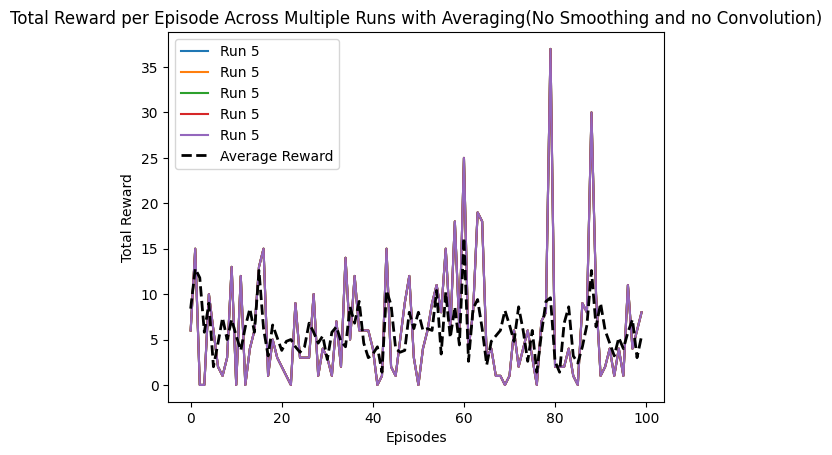

     Repetition  Episode  Total Reward  Q Value Before  Q Value After  \
0           1.0      1.0          19.0             NaN            NaN   
1           1.0      2.0          22.0             NaN            NaN   
2           1.0      3.0          49.0        1.031494       1.012690   
3           1.0      4.0           2.0        0.787418       0.785499   
4           1.0      5.0          10.0        0.910226       0.904795   
..          ...      ...           ...             ...            ...   
495         5.0     96.0           1.0        0.597194       0.595734   
496         5.0     97.0          11.0        0.642331       0.641484   
497         5.0     98.0           4.0        0.700614       0.700366   
498         5.0     99.0           6.0        0.666153       0.662954   
499         5.0    100.0           8.0        0.637855       0.636741   

     Priority  
0         1.0  
1         1.0  
2         1.0  
3         1.0  
4         1.0  
..        ...  
495       1

In [14]:
rewards_all_runs = []

for repetition in range(num_repetitons):
    rewards_per_episode = overall_training_neural_network(repetition)
    rewards_all_runs.append(rewards_per_episode)

rewards_all_runs = np.array(rewards_all_runs, dtype=object)

for repetiton in range(num_repetitons):
    plt.plot(rewards_all_runs[repetition], label=f'Run {repetition + 1}')

max_length = min(len(run) for run in rewards_all_runs)
avg_rewards = np.mean([run[:max_length] for run in rewards_all_runs], axis=0)
plt.plot(avg_rewards, label='Average Reward', color='black', linestyle='--', linewidth=2)

plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.title('Total Reward per Episode Across Multiple Runs with Averaging(No Smoothing and no Convolution)')
plt.legend(loc='upper left')
plt.show()

print(rewards_df)


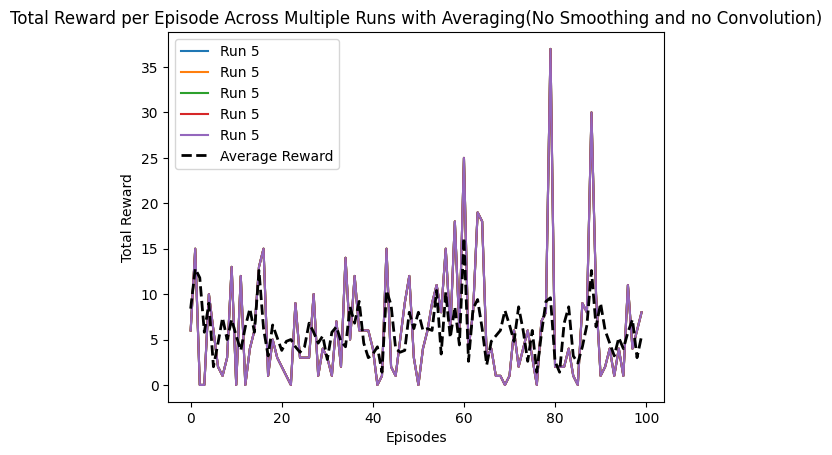

     Repetition  Episode  Total Reward  Q Value Before  Q Value After  \
0           1.0      1.0          19.0             NaN            NaN   
1           1.0      2.0          22.0             NaN            NaN   
2           1.0      3.0          49.0        1.031494       1.012690   
3           1.0      4.0           2.0        0.787418       0.785499   
4           1.0      5.0          10.0        0.910226       0.904795   
..          ...      ...           ...             ...            ...   
495         5.0     96.0           1.0        0.597194       0.595734   
496         5.0     97.0          11.0        0.642331       0.641484   
497         5.0     98.0           4.0        0.700614       0.700366   
498         5.0     99.0           6.0        0.666153       0.662954   
499         5.0    100.0           8.0        0.637855       0.636741   

     Priority  
0         1.0  
1         1.0  
2         1.0  
3         1.0  
4         1.0  
..        ...  
495       1

In [16]:
for repetiton in range(num_repetitons):
    plt.plot(rewards_all_runs[repetition], label=f'Run {repetition + 1}')

max_length = min(len(run) for run in rewards_all_runs)
avg_rewards = np.mean([run[:max_length] for run in rewards_all_runs], axis=0)
plt.plot(avg_rewards, label='Average Reward', color='black', linestyle='--', linewidth=2)

plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.title('Total Reward per Episode Across Multiple Runs with Averaging(No Smoothing and no Convolution)')
plt.legend(loc='upper left')
plt.show()

print(rewards_df)

In [15]:
rewards_df.to_csv("rewards_df.csv", index=False)